In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [18]:
# load the raw data
df=pd.read_csv('data/Air_Quality.csv')

In [20]:
#Then I found that there are some missing values in the dataset. So I drop the rows with missing values. And the "message" column is not useful for the analysis, so I drop it.
df['Message'].isna().sum() #show number of missing values in the column 'Message'
clean_data = df.drop(columns=['Message'])

In [21]:
clean_data['Start_Date'] = pd.to_datetime(df['Start_Date'])
clean_data.dropna(subset=['Data Value'], inplace=True)

In [23]:
#Then I found that the 'Time Period' column is hard to analyze, so I need to split it into different columns.
unique_time_periods = df['Time Period'].unique()
unique_time_periods[:10]
# Function to extract season from the 'Time Period' column
def extract_season(time_period):
    if 'Winter' in time_period:
        return 'Winter'
    elif 'Spring' in time_period:
        return 'Spring'
    elif 'Summer' in time_period:
        return 'Summer'
    elif 'Fall' in time_period:
        return 'Fall'
    else:
        return 'Annual'  # mark non-seasonal data as 'Annual'

# Apply the function to the 'Time Period' column
clean_data['Season'] = df['Time Period'].apply(extract_season)
# Display the first few rows of the modified dataframe
# clean_data.sample(5)

In [24]:
#Since the type of 'Time Period' is string, I need to convert it to numeric type.
def calculate_year(time_period):
    parts = time_period.replace('-', ' ').split() # Split the string by spaces and by dash

    years = [int(part) for part in parts if part.isdigit()]
    
    # If there are two years, return the first year
    if len(years) == 2:
        if years[1] < 100:
            years[1] += years[0] - (years[0] % 100)  
        return years[0]  
    elif len(years) == 1:
        return years[0]  
    else:
        dash_parts = [part for part in time_period.split() if '-' in part]
        for part in dash_parts:

            split_years = part.split('-')
            if all(s.isdigit() for s in split_years):
                # Parse the years and return the first one
                range_years = [int(s) for s in split_years]
                #print(range_years)
                if range_years:
                    return range_years[0]
        return np.nan 
    
# Apply the function to calculate the representative year
clean_data['Year'] = df['Time Period'].apply(calculate_year)
# clean_data.sample(5)

In [25]:
#drop the row "Time Period"
clean_data.drop(columns=['Time Period'], inplace=True)
# clean_data.sample(5)

In [26]:
cleaned_file_path = 'data/clean_data.csv'
clean_data.to_csv(cleaned_file_path, index=False)

In [57]:
clean_data.sample(5)

,Unique ID,Indicator ID,Name,Measure,Measure Info,Geo Type Name,Geo Join ID,Geo Place Name,Start_Date,Data Value,Season,Year
11798,649861,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF34,408,Jamaica,2019-01-01,6.24,Annual,2019
3405,669675,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF34,209,Bensonhurst - Bay Ridge,2019-12-01,7.56,Winter,2019
14438,173108,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF34,401,Long Island City - Astoria,2008-12-01,13.59,Winter,2008
7330,130475,641,Boiler Emissions- Total PM2.5 Emissions,Number per km2,number,UHF42,403,Flushing - Clearview,2013-01-01,0.60,Annual,2013
4398,167671,375,Nitrogen dioxide (NO2),Mean,ppb,CD,403,Jackson Heights (CD3),2010-12-01,24.74,Annual,2011


In [70]:
clean_data['Geo Type Name'].value_counts()

Geo Type Name
UHF42       6300
CD          5900
UHF34       3128
Borough      740
Citywide     150
Name: count, dtype: int64

In [66]:
# 加载GeoJSON文件
nyc_boroughs = gpd.read_file('data/nyc_boroughs.geojson')

# 显示GeoDataFrame的前10行
nyc_boroughs.head(10)

,name,cartodb_id,created_at,updated_at,geometry
0,Staten Island,1,2013-03-09 02:42:03.692000+00:00,2013-03-09 02:42:03.989000+00:00,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
1,Queens,2,2013-03-09 02:42:03.692000+00:00,2013-03-09 02:42:03.989000+00:00,"MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ..."
2,Brooklyn,3,2013-03-09 02:42:03.692000+00:00,2013-03-09 02:42:03.989000+00:00,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ..."
3,Manhattan,4,2013-03-09 02:42:03.692000+00:00,2013-03-09 02:42:03.989000+00:00,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
4,Bronx,5,2013-03-09 02:42:03.692000+00:00,2013-03-09 02:42:03.989000+00:00,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."


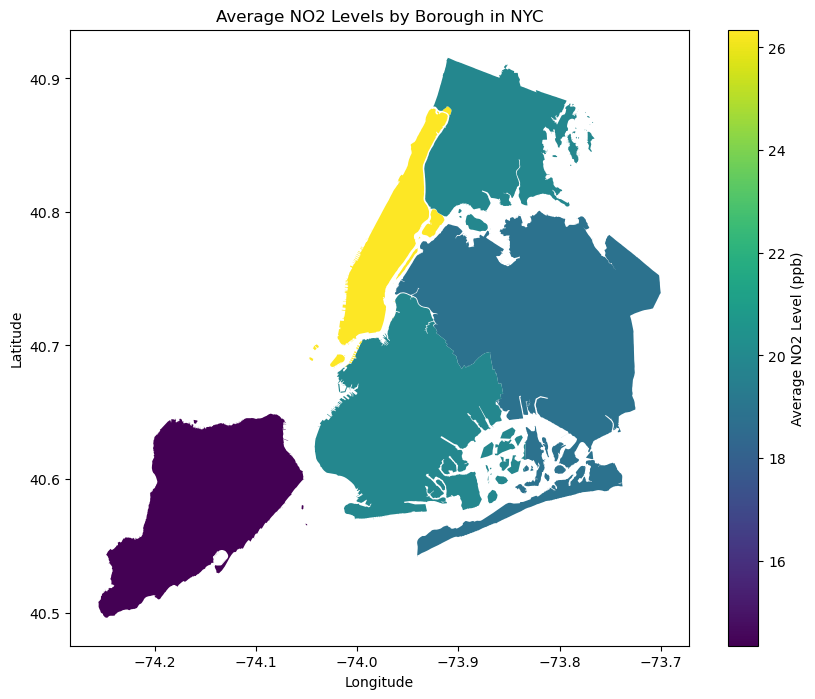

In [46]:
# 筛选NO2数据集中的NO2数据
no2_data = clean_data[clean_data['Name'] == 'Nitrogen dioxide (NO2)']
# 计算每个区的平均NO2水平
avg_no2_by_name = no2_data.groupby('Geo Place Name')['Data Value'].mean().reset_index()
# 将NO2数据集与GeoJSON文件合并
# 请确保'Geo Place Name'是NO2数据集中代表地区名称的列
merged_data = nyc_boroughs.merge(avg_no2_by_name, how='left', left_on='name', right_on='Geo Place Name')
# 绘制合并后的数据
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
merged_data.plot(column='Data Value', ax=ax, legend=True, legend_kwds={'label': "Average NO2 Level (ppb)"})
plt.title('Average NO2 Levels by Borough in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


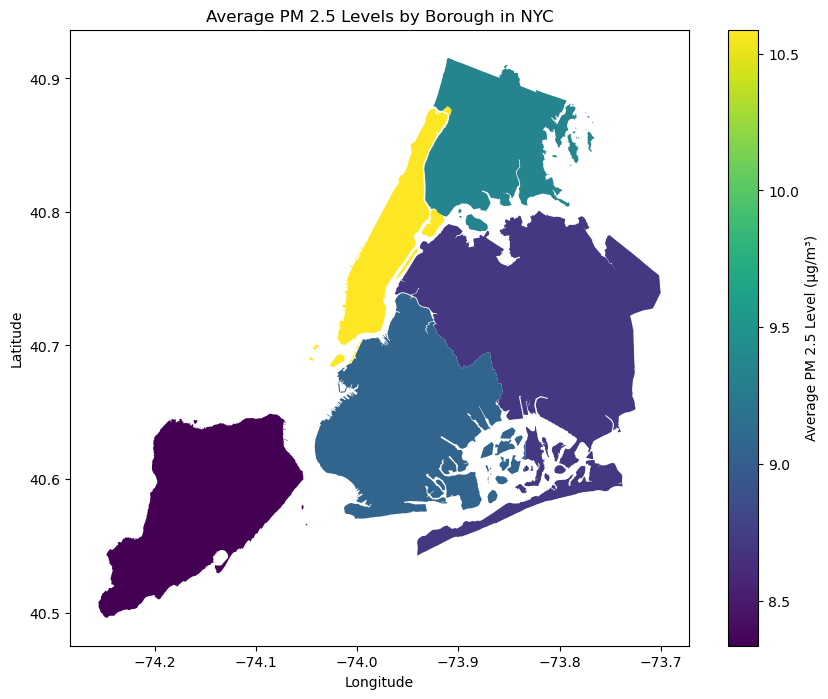

In [47]:
pm_data = clean_data[clean_data['Name'] == 'Fine particles (PM 2.5)']
avg_pm_by_name = pm_data.groupby('Geo Place Name')['Data Value'].mean().reset_index()
merged_data = nyc_boroughs.merge(avg_pm_by_name, how='left', left_on='name', right_on='Geo Place Name')

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
merged_data.plot(column='Data Value', ax=ax, legend=True, legend_kwds={'label': "Average PM 2.5 Level (µg/m³)"})
plt.title('Average PM 2.5 Levels by Borough in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

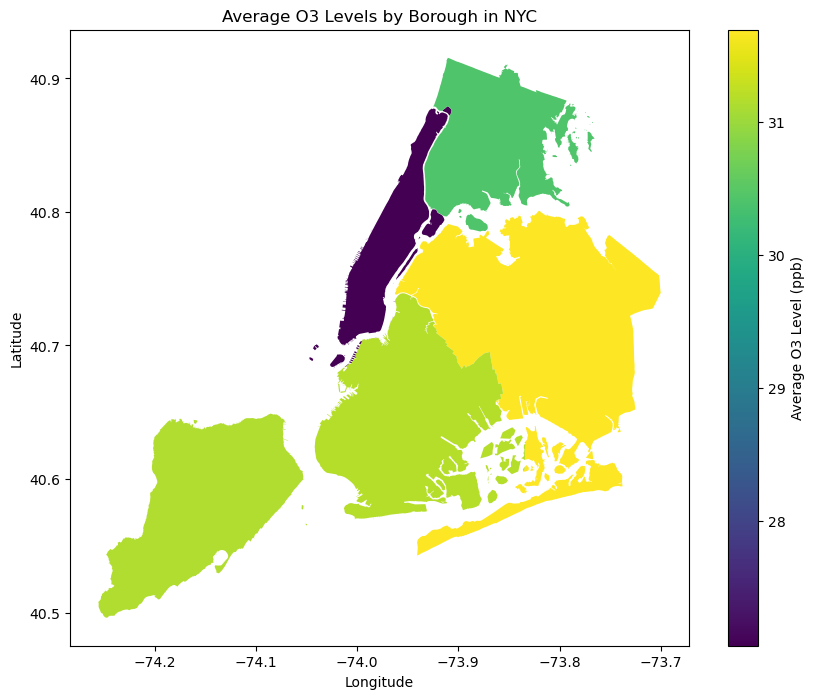

In [54]:
o3_data = clean_data[clean_data['Name'] == 'Ozone (O3)']
avg_o3_by_name = o3_data.groupby('Geo Place Name')['Data Value'].mean().reset_index()
merged_data = nyc_boroughs.merge(avg_o3_by_name, how='left', left_on='name', right_on='Geo Place Name')

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
merged_data.plot(column='Data Value', ax=ax, legend=True, legend_kwds={'label': "Average O3 Level (ppb)"})
plt.title('Average O3 Levels by Borough in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [65]:
# 加载GeoJSON文件
uhf42_geo_path = 'data/UHF42.geo.json'
uhf42_gdf = gpd.read_file(uhf42_geo_path)
# Display the first few rows to confirm successful loading and to show the structure
uhf42_gdf.head()


,id,GEOCODE,GEONAME,BOROUGH,geometry
0,101,101,Kingsbridge - Riverdale,Bronx,"POLYGON ((-73.87793 40.90556, -73.90217 40.912..."
1,102,102,Northeast Bronx,Bronx,"POLYGON ((-73.81504 40.88900, -73.82285 40.891..."
2,103,103,Fordham - Bronx Park,Bronx,"POLYGON ((-73.85627 40.88315, -73.85588 40.883..."
3,104,104,Pelham - Throgs Neck,Bronx,"MULTIPOLYGON (((-73.88366 40.82153, -73.88055 ..."
4,105,105,Crotona - Tremont,Bronx,"POLYGON ((-73.91444 40.85978, -73.91292 40.861..."


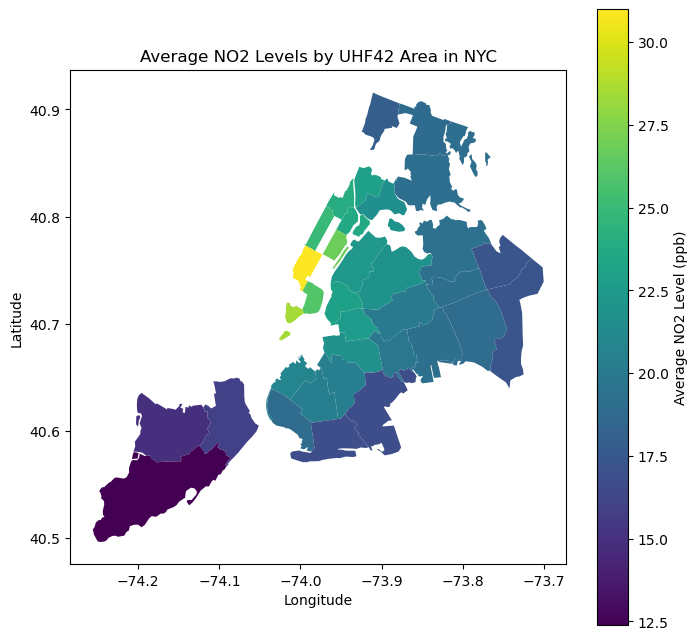

In [74]:
no2_data = clean_data[clean_data['Name'] == 'Nitrogen dioxide (NO2)']
# Calculate the average NO2 levels by UHF42 area
avg_no2_by_uhf42 = no2_data.groupby('Geo Place Name')['Data Value'].mean().reset_index()
# Merge the NO2 data with the UHF42 GeoDataFrame
merged_data = uhf42_gdf.merge(avg_no2_by_uhf42, how='left', left_on='GEONAME', right_on='Geo Place Name')
# Plotting the merged data
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
merged_data.plot(column='Data Value', ax=ax, legend=True, legend_kwds={'label': "Average NO2 Level (ppb)"})
plt.title('Average NO2 Levels by UHF42 Area in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

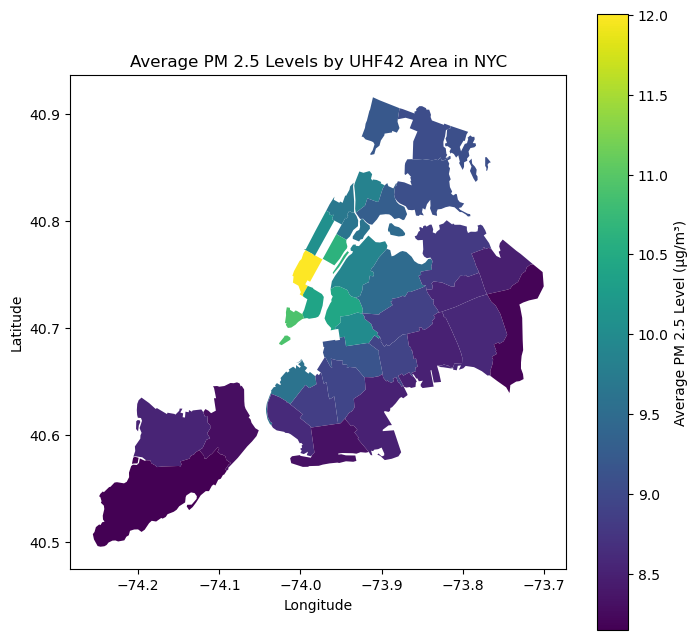

In [75]:
pm_data = clean_data[clean_data['Name'] == 'Fine particles (PM 2.5)']
avg_pm_by_uhf42 = pm_data.groupby('Geo Place Name')['Data Value'].mean().reset_index()
merged_data = uhf42_gdf.merge(avg_pm_by_uhf42, how='left', left_on='GEONAME', right_on='Geo Place Name')

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
merged_data.plot(column='Data Value', ax=ax, legend=True, legend_kwds={'label': "Average PM 2.5 Level (µg/m³)"})
plt.title('Average PM 2.5 Levels by UHF42 Area in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


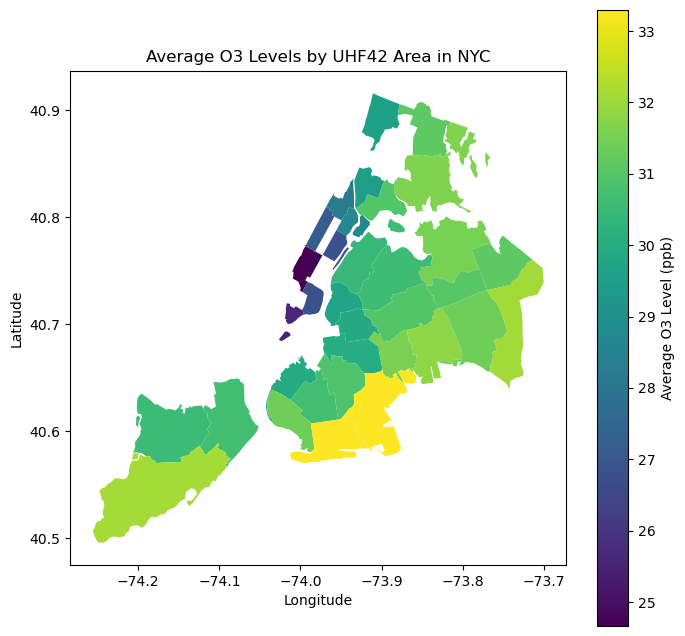

In [76]:
o3_data = clean_data[clean_data['Name'] == 'Ozone (O3)']
avg_o3_by_uhf42 = o3_data.groupby('Geo Place Name')['Data Value'].mean().reset_index()
merged_data = uhf42_gdf.merge(avg_o3_by_uhf42, how='left', left_on='GEONAME', right_on='Geo Place Name')

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
merged_data.plot(column='Data Value', ax=ax, legend=True, legend_kwds={'label': "Average O3 Level (ppb)"})
plt.title('Average O3 Levels by UHF42 Area in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()